## Hypothesis testing in python

In this workbook we will explore how to conduct basic hypothesis testing between two or more groups for comparing means and comparing proportions.

We will use the hotel bookings data from 5 different cities for this exercise. This data is taken from [Agoda](https://www.agoda.com/). See the data dictionary in workbook 1.

**Part 1 : Comparing two groups - 1 sample & 2 sample t test, z test for proportions**

In this part we will compare one or two samples and test if their means or proportions are significantly different using standard t-test.

**Part 2 : Comparing more than two groups - ANOVA & post hoc test**

In this part we will compare more than two samples and test if their means or proportions are significantly different using ANOVA.

In [17]:
##################################
# Import libraries and data
##################################

# libraries
import os
import time
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.proportion import proportions_ztest as pz
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.5)

# data
city_a = pd.read_csv('./data/city_a.csv')
city_a['city_name'] = 'city_a'
city_b = pd.read_csv('./data/city_b.csv')
city_b['city_name'] = 'city_b'
city_c = pd.read_csv('./data/city_c.csv')
city_c['city_name'] = 'city_c'
city_d = pd.read_csv('./data/city_d.csv')
city_d['city_name'] = 'city_d'
city_e = pd.read_csv('./data/city_e.csv')
city_e['city_name'] = 'city_e'

all_city = city_a.append([city_b, city_c, city_d, city_e]).reset_index(drop=True)

# convert dates to correct format
all_city['booking_date'] = pd.to_datetime(all_city['booking_date'],dayfirst=True)
all_city['checkin_date'] = pd.to_datetime(all_city['checkin_date'],dayfirst=True)
all_city['checkout_date'] = pd.to_datetime(all_city['checkout_date'],dayfirst=True)

#rename accommodation name
all_city = all_city.rename(columns={'accommodation_type_name':'acc_name'})

# add some derived variables
all_city['bc_gap'] = (all_city['checkin_date'] - all_city['booking_date']).dt.days
all_city['stay_dur'] = (all_city['checkout_date'] - all_city['checkin_date']).dt.days
all_city['month'] = all_city['checkin_date'].dt.month

all_city.head()

,book_id,ADR_USD,hotel_id,city_id,star_rating,acc_name,chain_hotel,booking_date,checkin_date,checkout_date,checkin_day,city_name,bc_gap,stay_dur,month
0,1,71.06,297388,9395,2.5,Hotel,non-chain,2016-08-02,2016-10-01,2016-10-02,weekend,city_a,60,1,10
1,2,76.56,298322,9395,3.0,Hotel,non-chain,2016-08-02,2016-10-01,2016-10-02,weekend,city_a,60,1,10
2,3,153.88,2313076,9395,5.0,Hotel,chain,2016-08-02,2016-10-01,2016-10-02,weekend,city_a,60,1,10
3,4,126.60,2240838,9395,3.5,Hotel,non-chain,2016-08-04,2016-10-02,2016-10-03,weekend,city_a,59,1,10
4,5,115.08,2240838,9395,3.5,Hotel,non-chain,2016-08-04,2016-10-02,2016-10-03,weekend,city_a,59,1,10


### Part 1 : Comparing two samples - means and proportions

 - comparing mean of a sample with population mean - 1 sample test
 - comparing means of two independent samples with each other
 - comparing means of two paired samples with each other
 - comparing proportions of 1 sample with population 
 - comparing proportions of two samples with each other

In [2]:
###########################################################
# 1. 1 sample test : comparing sample mean to population
# we will compare the mean ADR of one of the cities to global 
# ADR mean and see if its significantly different or not
###########################################################

def one_samp_ttest(data, mu, conf):

    print('***************************')
    print('Sample Mean :', np.round(np.mean(data),2), 'Population mean :', np.round(mu,2))
    print('T-statistics : ',stats.ttest_1samp(data,mu)[0])
    print('p-value : ',stats.ttest_1samp(data,mu)[1])
    
    if stats.ttest_1samp(data,mu)[1] < (1-conf):
        print('Null hypothesis rejected, the sample mean is not the same as the population mean!')
    else:
        print('Null hypothesis cannot be rejected, the sample mean is the same as the population mean!')
    print('\n')
        
        
pop_mean = np.mean(all_city['ADR_USD'])

print('Test the population mean to itself:')
one_samp_ttest(all_city['ADR_USD'], pop_mean, 0.95)

print('Test the population mean to City A mean:')
one_samp_ttest(all_city[all_city['city_name']=='city_a']['ADR_USD'], pop_mean, 0.95)

print('Test the population mean to City B mean:')
one_samp_ttest(all_city[all_city['city_name']=='city_b']['ADR_USD'], pop_mean, 0.95)

Test the population mean to itself:
***************************
Sample Mean : 148.09 Population mean : 148.09
T-statistics :  -1.069887195320358e-12
p-value :  0.9999999999991463
Null hypothesis cannot be rejected, the sample mean is the same as the population mean!


Test the population mean to City A mean:
***************************
Sample Mean : 100.51 Population mean : 148.09
T-statistics :  -106.94002311853069
p-value :  0.0
Null hypothesis rejected, the sample mean is not the same as the population mean!


Test the population mean to City B mean:
***************************
Sample Mean : 118.32 Population mean : 148.09
T-statistics :  -15.588383416613846
p-value :  1.6235661509189316e-53
Null hypothesis rejected, the sample mean is not the same as the population mean!




In [3]:
###########################################################
# 2. 2 sample test : comparing means of two independent samples
# we will compare the mean ADR of two different groups
# and see if they are significantly different or not
###########################################################

def two_samp_ttest(data1, data2, conf, pair=0):
    print('***************************')
    print('Sample 1 Mean :', np.round(np.mean(data1),2), 'Sample 2 mean :', np.round(np.mean(data2),2))
    
    if pair == 0:
        
        print('T-statistics : ',stats.ttest_ind(data1, data2)[0])
        print('p-value : ',stats.ttest_ind(data1, data2)[1])
        if stats.ttest_ind(data1, data2)[1] < (1-conf):
            print('Null hypothesis REJECTED, the two sample means are not the same!')
        else:
            print('Null hypothesis NOT REJECTED, the two sample means are the same!')
    else:
        
        print('T-statistics : ',stats.ttest_rel(data1, data2)[0])
        print('p-value : ',stats.ttest_rel(data1, data2)[1])
        if stats.ttest_rel(data1, data2)[1] < (1-conf):
            print('Null hypothesis REJECTED, the two sample means are not the same!')
        else:
            print('Null hypothesis NOT REJECTED, the two sample means are the same!')
            
    print('\n')

     
print('Test the population mean to itself:')
two_samp_ttest(all_city['ADR_USD'], all_city['ADR_USD'], 0.95)

print('Test the population mean to City A mean:')
two_samp_ttest(all_city[all_city['city_name']=='city_a']['ADR_USD'], all_city['ADR_USD'], 0.95)

print('Test the City A mean to City B mean:')
two_samp_ttest(all_city[all_city['city_name']=='city_a']['ADR_USD'], \
               all_city[all_city['city_name']=='city_b']['ADR_USD'], 0.95)


###########################################################
# 3. 2 sample test : comparing means of two paired samples
# group 1 : hotel id's first date average ADR
# group 2 : same hotel id's last date average ADR
###########################################################

hotel_day_adr = all_city.groupby(by=['hotel_id', 'booking_date'], as_index=False).agg({'ADR_USD':'mean'})\
                    .sort_values(by=['hotel_id','booking_date'], ascending=['True', 'True'])\
                    .reset_index(drop=True)

hotel_day_adr_min = hotel_day_adr.groupby(by='hotel_id', as_index=False)['booking_date'].min()
hotel_day_adr_min = hotel_day_adr.merge(hotel_day_adr_min,on=['hotel_id', 'booking_date'], how='inner')

hotel_day_adr_max = hotel_day_adr.groupby(by='hotel_id', as_index=False)['booking_date'].max()
hotel_day_adr_max = hotel_day_adr.merge(hotel_day_adr_max,on=['hotel_id', 'booking_date'], how='inner')

print('Test the first and last day average ADR :')
two_samp_ttest(hotel_day_adr_min['ADR_USD'], hotel_day_adr_max['ADR_USD'], 0.95, pair=1)

Test the population mean to itself:
***************************
Sample 1 Mean : 148.09 Sample 2 mean : 148.09
T-statistics :  0.0
p-value :  1.0
Null hypothesis NOT REJECTED, the two sample means are the same!


Test the population mean to City A mean:
***************************
Sample 1 Mean : 100.51 Sample 2 mean : 148.09
T-statistics :  -49.90025333439419
p-value :  0.0
Null hypothesis REJECTED, the two sample means are not the same!


Test the City A mean to City B mean:
***************************
Sample 1 Mean : 100.51 Sample 2 mean : 118.32
T-statistics :  -13.6519632610871
p-value :  2.7064790045250752e-42
Null hypothesis REJECTED, the two sample means are not the same!


Test the first and last day average ADR :
***************************
Sample 1 Mean : 151.58 Sample 2 mean : 157.56
T-statistics :  -2.198091662638224
p-value :  0.028202635349807943
Null hypothesis REJECTED, the two sample means are not the same!




In [8]:
###########################################################
# 4. 2 sample test : comparing proportions of one/two samples
# we will compare the proportions of "Hotels" in two cities
# and see if they are significantly different
# we can use proportions_ztest from statsmodel or binom_test from scipy.stats
###########################################################

pop_count = all_city[all_city['acc_name'] == 'Hotel']['hotel_id'].nunique()
pop_hotel = all_city['hotel_id'].nunique()

cityb_count = all_city[(all_city['city_name'] == 'city_b') & \
                       (all_city['acc_name'] == 'Hotel')]['hotel_id'].nunique()
cityb_hotel = all_city[(all_city['city_name'] == 'city_b')]['hotel_id'].nunique()

cityc_count = all_city[(all_city['city_name'] == 'city_c') & \
                       (all_city['acc_name'] == 'Hotel')]['hotel_id'].nunique()
cityc_hotel = all_city[(all_city['city_name'] == 'city_c')]['hotel_id'].nunique()

###########################################
# 1 sample proportions test
###########################################

print('Proportion comparison of Overall cities vs City C :')
print('***************************')
print('Group 1 prportion :', np.round(1.0*cityc_count/cityc_hotel,2))
print('Population proportion :', np.round(1.0*pop_count/pop_hotel,2))
print('T-statistics : ', pz(cityc_count, cityc_hotel, 1.0*pop_count/pop_hotel)[0])
print('p-value : ', pz(cityc_count, cityc_hotel, 1.0*pop_count/pop_hotel)[1])

if pz(cityc_count, cityc_hotel, 1.0*pop_count/pop_hotel)[1] < 0.05:
    print('Null hypothesis rejected, the sample 1 proportion is not the same as the population!')
else:
    print('Null hypothesis cannot be rejected, the sample 1 proportion is the same as the population!')
print('\n') 

###########################################
# 2 sample proportions test
###########################################

def two_sample_proptest(counts, sizes, conf=0.95):
    print('***************************')
    print('Group 1 prportion :', np.round(1.0*counts[0]/sizes[0],2))
    print('Group 2 proportion :', np.round(1.0*counts[1]/sizes[1],2))
    print('T-statistics : ', pz(counts, sizes)[0])
    print('p-value : ', pz([pop_count, cityb_count], [pop_hotel, cityb_hotel])[1])

    if pz([pop_count, cityb_count], [pop_hotel, cityb_hotel])[1] < (1-conf):
        print('Null hypothesis rejected, the sample 1 proportion is not the same as the sample 2 proportion!')
    else:
        print('Null hypothesis cannot be rejected, the sample 1 proportion is the same as the sample 2 proportion!')
    print('\n')
    

print('Proportion comparison of Overall cities vs City C :')
two_sample_proptest([pop_count, cityc_count], [pop_hotel, cityc_hotel])

print('Proportion comparison of City C vs City B :')
two_sample_proptest([cityc_count, cityb_count], [cityc_hotel, cityb_hotel])

Proportion comparison of Overall cities vs City C :
***************************
Group 1 prportion : 0.45
Population proportion : 0.37
T-statistics :  1.7897562086670171
p-value :  0.0734931118975907
Null hypothesis cannot be rejected, the sample 1 proportion is the same as the population!


Proportion comparison of Overall cities vs City C :
***************************
Group 1 prportion : 0.37
Group 2 proportion : 0.45
T-statistics :  -1.695381983373017
p-value :  2.209546706849973e-05
Null hypothesis rejected, the sample 1 proportion is not the same as the sample 2 proportion!


Proportion comparison of City C vs City B :
***************************
Group 1 prportion : 0.45
Group 2 proportion : 0.24
T-statistics :  4.424064081918045
p-value :  2.209546706849973e-05
Null hypothesis rejected, the sample 1 proportion is not the same as the sample 2 proportion!




## Part 2 : Comparing more than two samples - ANOVA

Here we will perform 1-way ANOVA which compares multiple classes from the same treatment/dependent variable, and tells us if all of them are same or not.

The null hypothesis for this test is that the means of all the classes are the same and the the alternate hypotheis is that the means of all the classes are not the same. The alternate hypothesis doesn't tell us which of the classes are different or how many classes are different.

To further examine which classes are different we use post-hoc tests to determine that.

In [16]:
###############################################
# 1. Comparing mean ADR from different cities - 1 way ANOVA
###############################################

print('Test if the mean ADR of all 5 cities are the same:')
print('***************************')
print('City A mean :', np.round(np.mean(all_city[all_city['city_name'] == 'city_a']['ADR_USD']),2))
print('City B mean :', np.round(np.mean(all_city[all_city['city_name'] == 'city_b']['ADR_USD']),2))
print('City C mean :', np.round(np.mean(all_city[all_city['city_name'] == 'city_c']['ADR_USD']),2))
print('City D mean :', np.round(np.mean(all_city[all_city['city_name'] == 'city_d']['ADR_USD']),2))
print('City E mean :', np.round(np.mean(all_city[all_city['city_name'] == 'city_e']['ADR_USD']),2))

f_stat, pval = stats.f_oneway(np.asarray(all_city[all_city['city_name'] == 'city_a']['ADR_USD']),\
                                       np.asarray(all_city[all_city['city_name'] == 'city_b']['ADR_USD']),\
                                       np.asarray(all_city[all_city['city_name'] == 'city_c']['ADR_USD']),\
                                       np.asarray(all_city[all_city['city_name'] == 'city_d']['ADR_USD']),\
                                       np.asarray(all_city[all_city['city_name'] == 'city_e']['ADR_USD']))

print('F-statistics : ', f_stat)
print('p-value : ', pval)

if pval < 0.05:
    print('We can reject null hypothesis - all the cities mean ADR are not the same')
else:
    print('We cannot reject null hypothesis - all the cities mean ADR are the same')

Test if the mean ADR of all 5 cities are the same:
***************************
City A mean : 100.51
City B mean : 118.32
City C mean : 224.84
City D mean : 218.85
City E mean : 142.07
F-statistics :  2380.0338764643166
p-value :  0.0
We can reject null hypothesis - all the cities mean ADR are not the same


 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
city_a city_b  17.8101  0.001   12.495  23.1251   True
city_a city_c  124.331  0.001 119.6513 129.0106   True
city_a city_d 118.3397  0.001 114.2964 122.3831   True
city_a city_e  41.5601  0.001  36.1933  46.9269   True
city_b city_c 106.5209  0.001  100.201 112.8408   True
city_b city_d 100.5296  0.001  94.6653  106.394   True
city_b city_e    23.75  0.001  16.9057  30.5943   True
city_c city_d  -5.9912 0.0173 -11.2865   -0.696   True
city_c city_e -82.7709  0.001 -89.1343 -76.4075   True
city_d city_e -76.7797  0.001 -82.6909 -70.8684   True
------------------------------------------------------


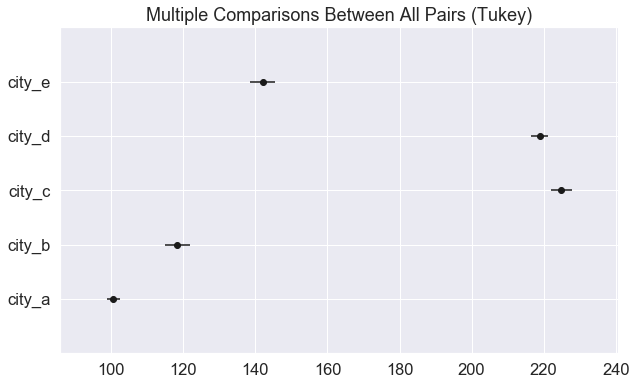

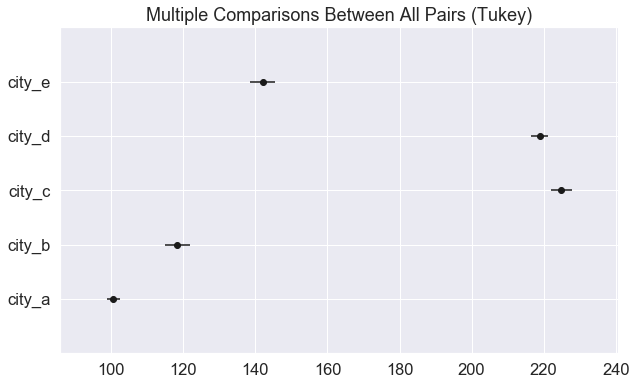

In [22]:
###############################################
# 1. Post Hoc test to find which of the groups are different
# we will use the statsmodel library and tukeyHSD test
# this can be done now using a new library in python - scikit-posthocs
###############################################

print(pairwise_tukeyhsd(all_city['ADR_USD'], all_city['city_name'], alpha=0.05))
pairwise_tukeyhsd(all_city['ADR_USD'], all_city['city_name'], alpha=0.05).plot_simultaneous()

From the above pairwise comparison we see that all the cities mean ADR are different from each other as we can reject all the null hypothesis from pairwise comparison (pvalue of all of the comparisons are < 0.05).